# Modeling the longterm outcome of stroke patients

In [20]:
# general
import pandas as pd
import numpy as np
from functions import helper

# plot libarys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Model preparation
#import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.dummy import DummyClassifier
 

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz  
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

## Cluster and Dimension Reduction
from kneed import KneeLocator
from sklearn.cluster import DBSCAN, MiniBatchKMeans, KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

# Model Metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score, make_scorer, adjusted_rand_score, precision_recall_curve

# Tensorflow
import os
import tensorflow as tf
from tensorboard.plugins import projector

# for merging the dataframes
import os, glob
import json

# further libarys
#import itertools
from sklearn.tree import export_graphviz
from collections import Counter

%matplotlib inline

In [6]:
df = pd.read_csv('data/IST_corrected_clean.csv',  index_col= [0])

In [7]:
# Only keep patients with an ischaemic stroke => df['DDIAGISC'].eq('Y')
#df = df[df['DDIAGISC'].eq('Y')]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18779 entries, 0 to 19434
Columns: 113 entries, HOSPNUM to RDISCH14
dtypes: float64(16), int64(29), object(68)
memory usage: 16.3+ MB


In [9]:
# Reset the index
df.index = pd.RangeIndex(len(df.index))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18779 entries, 0 to 18778
Columns: 113 entries, HOSPNUM to RDISCH14
dtypes: float64(16), int64(29), object(68)
memory usage: 16.2+ MB


## The target

After two weeks, we want to predict the recovery of patients after 6 months. Thus, we can exclude patients that have died within 14 days after their stroke.

In [11]:
df = df[df['DDEAD'] != 'Y']

A little recap: there are three variables for the longterm outcome. We are going to use "OCCODE" over "FRECOVER" and "FDENNIS" as this variable includes more information and is a little more conservative (e.g. patients who are labeled as recovered in "FRECOVER" and as dependent in "OCCODE"). See notebook XXX for more info.

In [12]:
print(f'Patients recovered: {round((df.OCCODE.value_counts()[2] / df.shape[0] * 100),1)} %')
print(f'Patients not recovered: {round((df.OCCODE.value_counts()[1] / df.shape[0] * 100),1)} %')
print(f'Patients dependent: {round((df.OCCODE.value_counts()[0] / df.shape[0] * 100),1)} %')
print(f'Patients deceased: {round((df.OCCODE.value_counts()[3] / df.shape[0] * 100),1)} %')

Patients recovered: 18.9 %
Patients not recovered: 22.3 %
Patients dependent: 46.1 %
Patients deceased: 12.7 %


We aim create a model that predicts whether a patient will recover within 6 months or not. For the latter we do not distinguish between "not recovered", "dependent" or "dead" (for now). For this we generate a new target column with 0 for recovered patients and 1 for all other outcomes.

## The features

For the prediction of the models we are going to use the variables for age, sex, blood pressure, possible deficits (e.g. arm/hand deficit, foot/leg deficit and such), indicator for non-cerebral bleeds as well as the indicator for any stroke, both within 14 days. 

Other variables were included in the first runs of the models (such as type of stroke), but were excluded as they did not improve the models and we aimed at building simple models. 

In [13]:
# drop missing values from 'RATRIAL'
df = df.dropna(subset = ['RATRIAL'])

In [14]:
# Select features
features = ['SEX', 'AGE', 'RSBP', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'NCB14', 'STRK14', 'RATRIAL']
X = df[features]

# Select target NRECO
y = df.OCCODE

There are no "U" (unknowns) in the selected features. If there had been, we would have drop those instances as they would not have provided any useful information.

In [27]:
object_col = list(X.select_dtypes(include='object').columns)

# Iterate over object columns
for column in object_col:
    columnSeriesObj = X[column]
    print()
    print('Colunm Name: ', column)
    print('Describe: ', columnSeriesObj.describe())
    if columnSeriesObj.nunique() <= 6:
        print('Unique values: ', columnSeriesObj.unique())
        print('Value counts: ', columnSeriesObj.value_counts()) # Check Categories (particularly 'U' = 'Unknown')


Colunm Name:  SEX
Describe:  count     15941
unique        2
top           M
freq       8605
Name: SEX, dtype: object
Unique values:  ['F' 'M']
Value counts:  M    8605
F    7336
Name: SEX, dtype: int64

Colunm Name:  RDEF1
Describe:  count     15941
unique        3
top           Y
freq      11446
Name: RDEF1, dtype: object
Unique values:  ['Y' 'N' 'C']
Value counts:  Y    11446
N     4334
C      161
Name: RDEF1, dtype: int64

Colunm Name:  RDEF2
Describe:  count     15941
unique        3
top           Y
freq      13607
Name: RDEF2, dtype: object
Unique values:  ['Y' 'N' 'C']
Value counts:  Y    13607
N     2247
C       87
Name: RDEF2, dtype: int64

Colunm Name:  RDEF3
Describe:  count     15941
unique        3
top           Y
freq      11907
Name: RDEF3, dtype: object
Unique values:  ['Y' 'N' 'C']
Value counts:  Y    11907
N     3843
C      191
Name: RDEF3, dtype: int64

Colunm Name:  RDEF4
Describe:  count     15941
unique        3
top           N
freq       8829
Name: RDEF4, dtype:

In [17]:
print(Counter(y))

Counter({'Dependent': 7357, 'Not recovered': 3521, 'Recovered': 3023, 'Dead': 2040})


In [21]:
# summarize class distribution
print(Counter(y))
# Oversampling from 1:4 to 1:2
strategy = {'Dependent': 5000, 'Not recovered': 5000, 'Recovered': 5000, 'Dead': 3000}
over = SMOTE(sampling_strategy= strategy, random_state= 42)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

Counter({'Dependent': 7357, 'Not recovered': 3521, 'Recovered': 3023, 'Dead': 2040})


ValueError: could not convert string to float: 'F'

In [28]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [29]:
#convert all 'objects' into 'categories'
X_train = pd.concat([
        X_train.select_dtypes([], ['object']),
        X_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_train.columns, axis=1)

In [30]:
#convert all 'objects' into 'categories' 
X_test = pd.concat([
        X_test.select_dtypes([], ['object']),
        X_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_test.columns, axis=1)

### Preparation of Data Scaling and Category Encoding
Some models need scaling of numerical features and encoding of categorical features. The sklearn preprocessors are instantiated here and used where necessary in the data transformation step of each model.

In [31]:
# encoder for categories
onehot = OneHotEncoder(drop="first")

# scalers for numerical features
mms = MinMaxScaler()
ss = StandardScaler()

# Prepare list of numerical and categorical columns
num_cols = make_column_selector(dtype_include=np.number)
cat_cols = make_column_selector(dtype_include='category')

## Dummy classifier


The baseline model was generated by implemented the dummy classifier from sklearn. We get a score of 81%, which needs to be beaten by the final model.

--- MODEL PARAMETERS ----------
{
    "constant": null,
    "random_state": 42,
    "strategy": "uniform"
}
--- CLASSIFICATION REPORT ----------
               precision    recall  f1-score   support

         Dead       0.12      0.25      0.16       612
    Dependent       0.47      0.25      0.33      2207
Not recovered       0.23      0.25      0.24      1057
    Recovered       0.20      0.26      0.22       907

     accuracy                           0.25      4783
    macro avg       0.25      0.25      0.24      4783
 weighted avg       0.32      0.25      0.27      4783

--- CONFUSION MATRIX ----------
[[152 159 151 150]
 [589 556 519 543]
 [270 246 265 276]
 [226 231 215 235]]


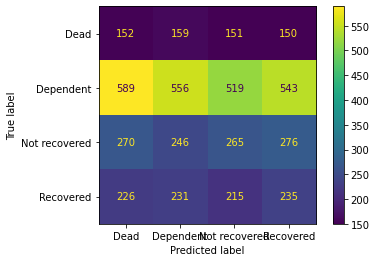

In [35]:
clf_dummy = DummyClassifier(strategy='uniform', random_state=42)
m_dummy = modeling.pred_eval_plot_model(X_train, X_test, y_train, y_test, clf_dummy)

+ accuracy 0.50
+ 0: prec .43 recall .49
+ 1: prec .57 recall .50

## Logistic Regression with Standard Scaler


In [36]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

--- MODEL PARAMETERS ----------
{
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 400,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l2",
    "random_state": 42,
    "solver": "lbfgs",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
               precision    recall  f1-score   support

         Dead       0.48      0.08      0.13       612
    Dependent       0.51      0.85      0.64      2207
Not recovered       0.37      0.18      0.24      1057
    Recovered       0.41      0.23      0.30       907

     accuracy                           0.49      4783
    macro avg       0.44      0.33      0.33      4783
 weighted avg       0.46      0.49      0.42      4783

--- CONFUSION MATRIX ----------
[[  46  540   11   15]
 [  44 1880  154  129]
 [   4  710  187  156]
 [   1  544  152  210]]


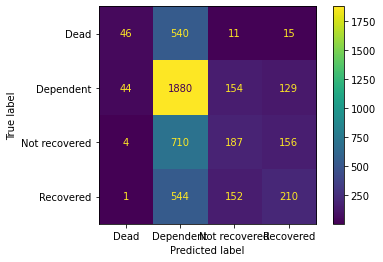

In [37]:
logreg_ss = LogisticRegression(max_iter=400, random_state= 42)
m_logreg_ss = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg_ss)

+ accuracy 0.67
+ 0: prec .62 recall .55
+ 1: prec .69 recall .75

Adjusting the threshold does improve the identification of non-recovered patients (recall = 1.0), but it decreases the recall of recovered patients substantially (0.03), same goes for the accuracy (0.53).

## Logistic Regression with MinMaxScaler

In [39]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

--- MODEL PARAMETERS ----------
{
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 400,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l2",
    "random_state": 42,
    "solver": "lbfgs",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
               precision    recall  f1-score   support

         Dead       0.54      0.07      0.13       612
    Dependent       0.51      0.86      0.64      2207
Not recovered       0.37      0.18      0.24      1057
    Recovered       0.41      0.23      0.29       907

     accuracy                           0.49      4783
    macro avg       0.46      0.33      0.33      4783
 weighted avg       0.47      0.49      0.42      4783

--- CONFUSION MATRIX ----------
[[  45  541   11   15]
 [  34 1891  152  130]
 [   3  712  186  156]
 [   1  547  151  208]]


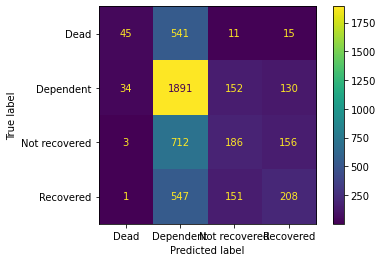

In [40]:
# Calculate the LogisticRegression
logreg = LogisticRegression(max_iter=400, random_state= 42)
m_logreg_mm = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg)

+ accuracy 0.67
+ 0: prec .63 recall .56
+ 1: prec .69 recall .75

Standard Scaler performed slightly (!) better than MinMax Scaler.

### Randomized GridSearch 

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END C=0.1, l1_ratio=0.25, max_iter=200, penalty=elasticnet, solver=saga; total time=   0.4s
[CV 2/3] END C=0.1, l1_ratio=0.25, max_iter=200, penalty=elasticnet, solver=saga; total time=   0.2s
[CV 3/3] END C=0.1, l1_ratio=0.25, max_iter=200, penalty=elasticnet, solver=saga; total time=   0.3s
[CV 1/3] END C=1000.0, l1_ratio=0.25, max_iter=200, penalty=elasticnet, solver=saga; total time=   0.4s
[CV 2/3] END C=1000.0, l1_ratio=0.25, max_iter=200, penalty=elasticnet, solver=saga; total time=   0.5s
/Users/Nicole/Documents/Data_Science/neuefische/projects/Capstone/stroke/Capstone/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[CV 3/3] END C=1000.0, l1_ratio=0.25, max_iter=200, penalty=elasticnet, solver=saga; total time=   2.3s
[CV 1/3] END C=0.1, l1_ratio=0.0, 

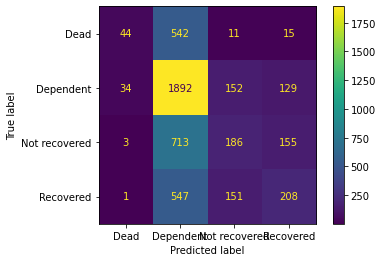

In [41]:
params_grid = {
    "penalty": ["elasticnet"],
    "C": np.logspace(-3, 3, 7),
    "max_iter": [200],
    "l1_ratio": np.arange(0, 1, 0.25),
    "solver": ["saga"],
}
rs_logreg = modeling.run_rand_grid_search(X_train_trans, X_test_trans, y_train, y_test, logreg, params_grid, cv=3, n_iter=20)

+ Best model: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 200, 'l1_ratio': 0.25, 'C': 100.0}
+ Best cross-validated Score: 0.6577867250557965
+ 0: prec 0.63, recall 0.56
+ 1: prec 0.69, recall 0.75
+ accuracy .67


## Decision Tree

For Decision Trees numerical data doesn't need to be scaled. Categorical data needs to be encoded. As One-Hot-Encoding leads to sparse data and decreases the performance of decision trees, we encode the categories numerically.

In [42]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

### Simple Decision Tree


In [43]:
# Define Classifier
dtree = DecisionTreeClassifier(random_state=42)

--- MODEL PARAMETERS ----------
{
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": null,
    "max_leaf_nodes": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "random_state": 42,
    "splitter": "best"
}
--- CLASSIFICATION REPORT ----------
               precision    recall  f1-score   support

         Dead       0.23      0.27      0.25       612
    Dependent       0.50      0.53      0.51      2207
Not recovered       0.29      0.26      0.27      1057
    Recovered       0.28      0.24      0.26       907

     accuracy                           0.38      4783
    macro avg       0.32      0.32      0.32      4783
 weighted avg       0.38      0.38      0.38      4783

--- CONFUSION MATRIX ----------
[[ 163  318   82   49]
 [ 381 1174  345  307]
 [  88  479  274  216]
 [  70  382  237  218]]


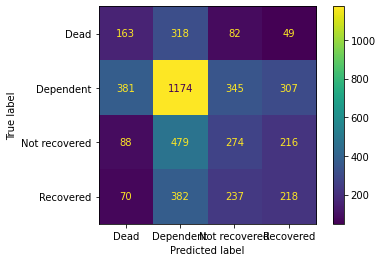

In [44]:
m_dtree = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, dtree)

+ 0       prec 0.67     recall 0.84 
+ 1       prec 0.85      recall 0.69 
+ accuracy 0.75

### Grid Search

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..............max_depth=36, min_samples_leaf=17; total time=   0.1s
[CV 2/5] END ..............max_depth=36, min_samples_leaf=17; total time=   0.1s
[CV 3/5] END ..............max_depth=36, min_samples_leaf=17; total time=   0.0s
[CV 4/5] END ..............max_depth=36, min_samples_leaf=17; total time=   0.1s
[CV 5/5] END ..............max_depth=36, min_samples_leaf=17; total time=   0.1s
[CV 1/5] END ..............max_depth=44, min_samples_leaf=23; total time=   0.1s
[CV 2/5] END ..............max_depth=44, min_samples_leaf=23; total time=   0.0s
[CV 3/5] END ..............max_depth=44, min_samples_leaf=23; total time=   0.0s
[CV 4/5] END ..............max_depth=44, min_samples_leaf=23; total time=   0.0s
[CV 5/5] END ..............max_depth=44, min_samples_leaf=23; total time=   0.1s
[CV 1/5] END ...............max_depth=30, min_samples_leaf=5; total time=   0.0s
[CV 2/5] END ...............max_depth=30, min_s

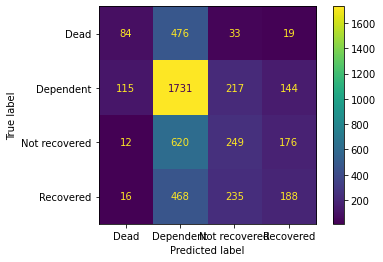

In [45]:
params_grid = {
    "max_depth": np.arange(10, 50, 2),
    "min_samples_leaf": np.arange(1, 30, 2),
}
rs_dtree = modeling.run_rand_grid_search(X_train_trans, X_test_trans, y_train, y_test, dtree, params_grid, n_iter=30)

+ Best model: {'min_samples_leaf': 1, 'max_depth': 32}
+ Best cross-validated Score: 0.7172234094908079
+ 0: prec 0.67, recall 0.84
+ 1: prec 0.85, recall 0.69

In [35]:
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
#export_graphviz(rs_dtree.best_estimator_, out_file ='tree.dot')

## Random Forest

In [46]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

### Simple Random Forest

In [47]:
# Define Classifier
rf = RandomForestClassifier(random_state = 42)

--- MODEL PARAMETERS ----------
{
    "bootstrap": true,
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": "auto",
    "max_leaf_nodes": null,
    "max_samples": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "n_estimators": 100,
    "n_jobs": null,
    "oob_score": false,
    "random_state": 42,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
               precision    recall  f1-score   support

         Dead       0.26      0.17      0.21       612
    Dependent       0.52      0.65      0.58      2207
Not recovered       0.33      0.27      0.30      1057
    Recovered       0.34      0.29      0.32       907

     accuracy                           0.44      4783
    macro avg       0.36      0.35      0.35      4783
 weighted avg       0.41      0.44      0.42   

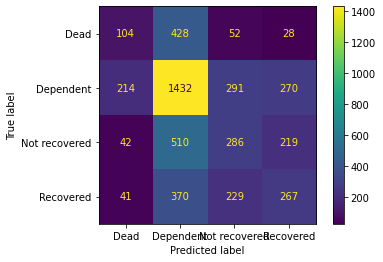

In [48]:
m_rf = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, rf)

+ accuracy is 0.78
+ 0: prec 0.71, recall 0.80
+ 1: prec 0.83, recall 0.76


In [49]:
# Calculate some stats for the random forest:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in m_rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 9249
Average maximum depth 34


### Grid Search

We want to check whether we can improve the performance of the random forest by changing the split-criterion. We will not regularize the depth of the tree and the minimum samples per leaf, as we are averaging the classification of 31 trees. Therefore, we assume that no additional regularization is necessary.

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .................................criterion=gini; total time=   1.5s
[CV 2/5] END .................................criterion=gini; total time=   1.7s
[CV 3/5] END .................................criterion=gini; total time=   1.9s
[CV 4/5] END .................................criterion=gini; total time=   1.4s
[CV 5/5] END .................................criterion=gini; total time=   1.4s
[CV 1/5] END ..............................criterion=entropy; total time=   1.6s
[CV 2/5] END ..............................criterion=entropy; total time=   1.6s
[CV 3/5] END ..............................criterion=entropy; total time=   1.5s
[CV 4/5] END ..............................criterion=entropy; total time=   1.5s
[CV 5/5] END ..............................criterion=entropy; total time=   1.7s
--- GRID SEARCH RESULTS ----------
Best model: {'criterion': 'gini'}
Best cross-validated Score: 0.42704852124431075
--- CLASSIFIC

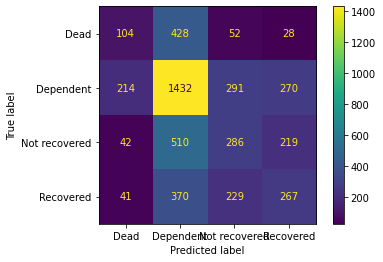

In [50]:
params_grid = {
    "criterion": ["gini", "entropy"],
}
rs_rf = modeling.run_grid_search(X_train_trans, X_test_trans, y_train, y_test, rf,  params_grid)

+ Best model: {'criterion': 'gini'}
+ Best cross-validated Score: 0.7499286515250596
+ 0: precision 0.71, recall 0.80
+ 1: precision 0.83, recall 0.76


## Extra Tree
### Simple Extra Tree Classifier

In [51]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

--- MODEL PARAMETERS ----------
{
    "bootstrap": false,
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": "auto",
    "max_leaf_nodes": null,
    "max_samples": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "n_estimators": 100,
    "n_jobs": null,
    "oob_score": false,
    "random_state": 42,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
               precision    recall  f1-score   support

         Dead       0.24      0.21      0.22       612
    Dependent       0.51      0.61      0.56      2207
Not recovered       0.32      0.27      0.29      1057
    Recovered       0.32      0.26      0.28       907

     accuracy                           0.42      4783
    macro avg       0.35      0.34      0.34      4783
 weighted avg       0.40      0.42      0.40  

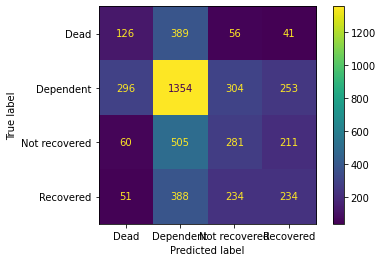

In [52]:
etree = ExtraTreesClassifier(random_state=42)
m_etree = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, etree)

+ accuracy: 79
+ 0: precision 0.72, recall 0.82
+ 1: precision 0.85, recall 0.76

## XGBoost
### Simple XGBoost

In [70]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

In [71]:
# Define Classifier
xgb = XGBClassifier(random_state = 42)

/Users/Nicole/Documents/Data_Science/neuefische/projects/Capstone/stroke/Capstone/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[12:16:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
--- MODEL PARAMETERS ----------
{
    "objective": "binary:logistic",
    "use_label_encoder": true,
    "base_score": 0.5,
    "booster": "gbtree",
    "colsample_bylevel": 1,
    "colsample_

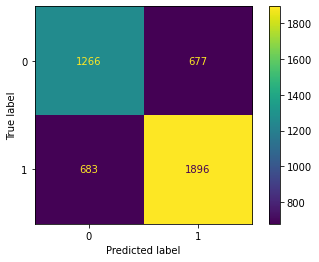

In [72]:
m_xgb = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, xgb)

+ accuracy .70
+ 0: precision 0.65, recall 0.65
+ 1: precision 0.74, recall 0.74

## K-Means

In [46]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

In [47]:
N_CLUSTERS = len(y_train.unique())

In [63]:
# Pipeline for PCA
prepro_pca = Pipeline([("pca", PCA(n_components=4, random_state=42)),])

In [64]:
# Pipeline for clusterer/Kmeans
clusterer = Pipeline([("kmeans", KMeans(n_clusters= N_CLUSTERS, init="k-means++", n_init=50, max_iter=500, random_state=42,),),])

In [65]:
pipe = Pipeline(
    [
        ("preprocessor", prepro_pca),
        ("clusterer", clusterer)
    ]
)

In [66]:
pipe.fit(X_train_trans)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pca',
                                  PCA(n_components=4, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=2, n_init=50,
                                         random_state=42))]))])

Adjusted rand index (ARI) uses true cluster assignments to measure the similarity between true and predicted labels. The ARI output values range between -1 and 1. A score close to 0.0 indicates random assignments, and a score close to 1 indicates perfectly labeled clusters.

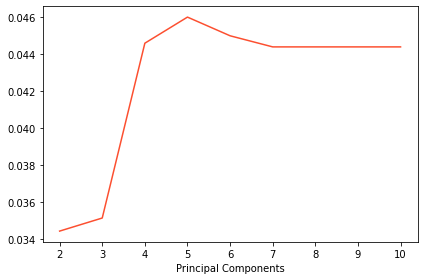

In [52]:
modeling_14d.ari_scores(pipe, pipe["preprocessor"]["pca"], pipe["clusterer"]["kmeans"], y_train, X_train_trans)

In [67]:
y_pred = pipe.predict(X_test_trans)

In [68]:
# PCA with 4 componenents
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[405 539]
 [189 681]]
              precision    recall  f1-score   support

           0       0.68      0.43      0.53       944
           1       0.56      0.78      0.65       870

    accuracy                           0.60      1814
   macro avg       0.62      0.61      0.59      1814
weighted avg       0.62      0.60      0.59      1814



+ accuracy 0.60
+ 0 prec 0.68, recall 0.43
+ 1 prec .56, recall 0.78


### MiniBatch KMeans

In [70]:
# Pipeline for PCA
prepro_pca = Pipeline([("pca", PCA(n_components=5, random_state=42)),])

# Pipeline for clusterer/Kmeans
clusterer = Pipeline([("batch_kmeans", MiniBatchKMeans(n_clusters=N_CLUSTERS, verbose=0, max_iter=150, n_init=20, random_state=42,),),])

#
pipe2 = Pipeline(
    [
        ("preprocessor", prepro_pca),
        ("clusterer", clusterer)
    ]
)

pipe2.fit(X_train_trans)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pca',
                                  PCA(n_components=5, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('batch_kmeans',
                                  MiniBatchKMeans(max_iter=150, n_clusters=2,
                                                  n_init=20,
                                                  random_state=42))]))])

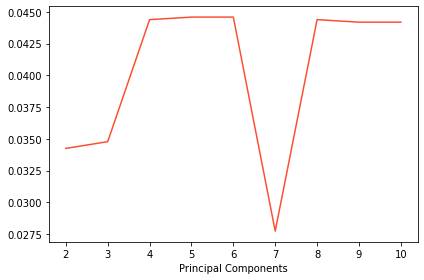

In [73]:
modeling_14d.ari_scores(pipe2, pipe2["preprocessor"]["pca"], pipe2["clusterer"]["batch_kmeans"], y_train, X_train_trans)

In [74]:
y_pred = pipe2.predict(X_test_trans)

In [75]:
# PCA with 5 components
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[407 537]
 [190 680]]
              precision    recall  f1-score   support

           0       0.68      0.43      0.53       944
           1       0.56      0.78      0.65       870

    accuracy                           0.60      1814
   macro avg       0.62      0.61      0.59      1814
weighted avg       0.62      0.60      0.59      1814



+ accuracy 0.60
+ 0 prec 0.67, recall 0.43
+ 1 prec .56, recall 0.78

### Agglomerative Clustering

In [78]:
# Pipeline for PCA
prepro_pca = Pipeline([("pca", PCA(n_components=6, random_state=42)),])

# Pipeline for Agglomoerative clustering
clusterer = Pipeline([("agg_clust", AgglomerativeClustering(n_clusters=2, linkage='ward',),),])

#
pipe3= Pipeline(
    [
        ("preprocessor", prepro_pca),
        ("clusterer", clusterer)
    ]
)

pipe3.fit(X_train_trans)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pca',
                                  PCA(n_components=6, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('agg_clust', AgglomerativeClustering())]))])

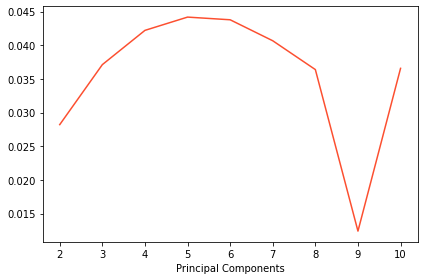

In [77]:
modeling_14d.ari_scores(pipe3, pipe3["preprocessor"]["pca"], pipe3["clusterer"]["agg_clust"], y_train, X_train_trans)

In [79]:
y_pred = pipe3.fit_predict(X_test_trans)

# PCA with 6 components
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[592 352]
 [701 169]]
              precision    recall  f1-score   support

           0       0.46      0.63      0.53       944
           1       0.32      0.19      0.24       870

    accuracy                           0.42      1814
   macro avg       0.39      0.41      0.39      1814
weighted avg       0.39      0.42      0.39      1814



+ accuracy 0.42
+ 0 prec 0.46, recall 0.63
+ 1 prec .32, recall 0.19

### DBSCAN


In [84]:
pca_ = PCA(n_components=4, random_state=42)
X_train_pca = pca_.fit_transform(X_train_trans)

To find the optimal epsilon for the DBSCAN algorithm, we will compute the following

(3500.0, 4200.0)

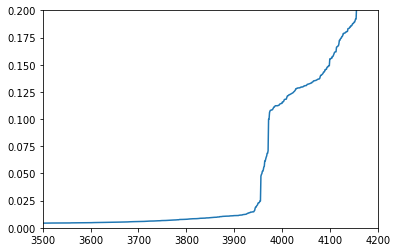

In [86]:
# calculate the distance from each point to its closest neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_train_pca)
# return two arrays containing the closest n_neighbors points and the index for each of these points
distances, indices = nbrs.kneighbors(X_train_pca)

# sort the results and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim([0, 0.2])
plt.xlim([3500, 4200])

The optimal value for epsilon is at tha point of the maximum curvature. After zooming into the plot we can see that 0.02 might be the best value for epsilon.

In [97]:
db_clust = DBSCAN(eps = 0.025, min_samples = 50).fit(X_train_pca)

In [98]:
ari_db_clust = adjusted_rand_score(y_train, db_clust.labels_)
ari_db_clust

0.010949425088370192

After adjusting the minimum of samples in a cluster, we could improve the ARI. Though, we DBSCAN find's too many clusters. 

In [99]:
pd.DataFrame(db_clust.labels_)[0].unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 10, 12])

## PCA-Plot


Let's have a closer look at the data and how it is distributed. By implementing PCA we reduce the dimensions of the data and are able to plot the datapoints in 2D and 3D. 

In [100]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

In [101]:
pca_ = PCA(random_state=42)
X_train_pca = pca_.fit_transform(X_train_trans)


We plotted the three first components of the PCA and we can see that we cannot distinguish between the two groups (yellow: not recovered, dependent, dead and blue: recovered).

In [102]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca_.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    X_train_pca,
    labels=labels,
    dimensions=range(4),
    color=y_train
)
fig.update_traces(diagonal_visible=False)
fig.show()

In a 3D plot we are able to rotate the cloud of points and still see that it is really hard to differentiate between the yellow and blue dots.

In [103]:
total_var = pca_.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    X_train_pca, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

By plotting the loadings of single variables we get an idea which variables contribute to the variation of the dataset and how the variables correlate with each other. Lines that a short have less impact on the variation than longer lines. Lines that point in the same direction and are close to each other correlate positively, lines that are going into opposite directions correlate negatively with each other. 

So "AGE", "RDEF1", "RSBP" and "SEX" probably can be excluded from the models as their loadings are fairly small compared to the other variables.
There seems to be a small separation along the first components. The variances of non-recovered patients (yellow) are driven by "NCB14", "RDEF6" and "RDEF4", whereas the the variances of recovered patients (blue) are more driven by the variables "RDEF3", "RDEF5" and "RDEF7".

In [104]:
loadings = pca_.components_.T * np.sqrt(pca_.explained_variance_)

fig = px.scatter(X_train_pca, x=0, y=1, color=y_train)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [106]:
#df_new = pd.merge(X, y, left_index=True, right_index=True)

In [113]:
#df_new.head()